In [67]:
# !pip install scipy
# !pip install ruptures

# imports

In [68]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt


# Dataset loading

In [281]:
filepath = './datasets/basic_motions/BasicMotions_TRAIN.arff'

def load_dataset_to_dataframe(path):
    """Load data that is stored within the path

    Args:
        path: string with path containing data
    Returns:
        A pandas dataframe with only data inside
    """
    dataset = arff.loadarff(path)
    df = pd.DataFrame(dataset[0])
    return df 

df = load_dataset_to_dataframe(filepath)


# Clear segementation off dataset 

6


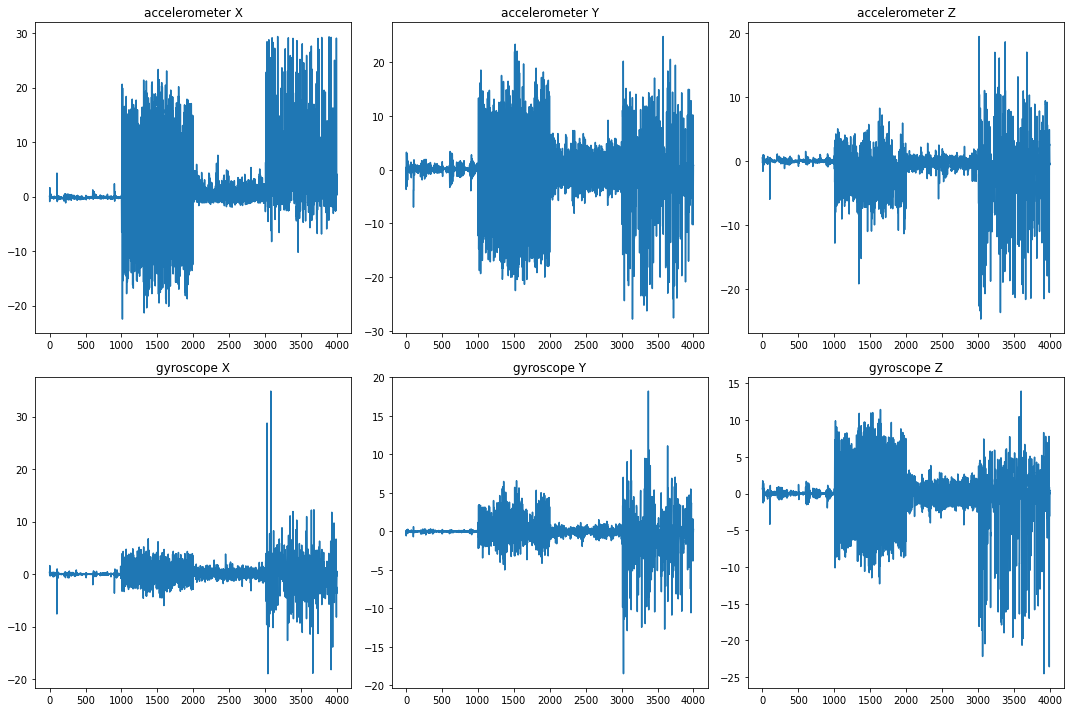

In [282]:
def stack_time_series(df):
    """This function creates new dataframe without segmentation and classification

    Args:
        df: segmented dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
    """
    dimensionality = df.iloc[0,0].shape[0] if type(df.iloc[0,0][0]) == np.void else 1  # assumption that data dimensionality is the number of rows of first element in dataframe
    # also the first column is expected to store data (second stores classification)
    chunk_size = len(df.iloc[0,0][0])
    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))
    
    # filling it with empty numpy arrays
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        if type(row[0][0]) == np.void:
            for r in row[0]:
                #print((type(r))==np.void)
                stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
                i += 1
        else:
             stacked.iloc[0,0] = np.concatenate((stacked.iloc[i,0],row[0]))
    return stacked

random_stacked, change_points = stack_time_series_randomly(df,42,100)
random_stacked = dataframe_to_ndarray(random_stacked)


def dataframe_to_ndarray(df):
    """This function creates ndarray(2 dmiensional, shape: length x dim) of dataframe (shape: dim x length)

    Args:
        df: dataframe
    Returns:
        A numpy array with shape: length x dim)
    """
    ndarray = np.array([])
    for index, row in df.iterrows():
        if index == 0:
            ndarray = row[0]
        else:
            ndarray = np.vstack((ndarray,row[0]))
    return ndarray.transpose()


stacked = stack_time_series(df)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot different data on each subplot
axs[0, 0].plot(stacked.iloc[0,0])
axs[0, 0].set_title('accelerometer X')

axs[0, 1].plot(stacked.iloc[1,0])
axs[0, 1].set_title('accelerometer Y')

axs[0, 2].plot(stacked.iloc[2,0])
axs[0, 2].set_title('accelerometer Z')

axs[1, 0].plot(stacked.iloc[3,0])
axs[1, 0].set_title('gyroscope X')

axs[1, 1].plot(stacked.iloc[4,0])
axs[1, 1].set_title('gyroscope Y')

axs[1, 2].plot(stacked.iloc[5,0])
axs[1, 2].set_title('gyroscope Z')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

n, dim = 4000, 6  # number of samples, dimension
n_bkps, sigma = 3, 5  # number of change points, noise standart deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)
# print((signal))
# print((signal).shape)

# plt.plot(signal)
# plt.show()

motion_basics_stacked_ndarray = dataframe_to_ndarray(stacked)

# plt.plot(motion_basics_stacked_ndarray)
# plt.show()

# # change point detection
# model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
# algo = rpt.Window(model=model).fit(motion_basics_stacked_ndarray)

# my_bkps = algo.predict(n_bkps=3)

# rpt.show.display(motion_basics_stacked_ndarray, bkps, my_bkps, figsize=(10, 6))
# plt.show()

# Evaluation 

In [304]:
# https://ceur-ws.org/Vol-1226/paper31.pdf

def points_labels_vector(n,change_points):
    """This function creates vector of predicated labels [0,0, ...,1,...0] 
    where 1 means time series at this index is change point, and 0 that there is no change point

    Args:
        n: count of time series
        change_points: 1-D numpy array with change point indexes
    Returns:
        A 1-D numpy array with lenght of n, containing ones and zeros
    """
    predicted_labels = np.zeros(n)
    predicted_labels[change_points] = 1
    return predicted_labels


def calculate_TP_TN_FP_FN(n, predicted_points, original_points, treshold):
    """This function calculates TP, TN, FP, FN , the change point is correct if its distance from original
    change point is closer then treshold, when there is more than one change point within the threshold the additional
    ones are considered FP

    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        A scalar values of TP, TN, FP, FN
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    TP = 0
    TN = 0
    FP = 0
    FN = 0
    zone_counter = np.zeros(len(original_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                which_point = np.argmin(np.abs(original_points - index))
                #print(original_points)
                #print(which_point)
                if zone_counter[which_point] == True :
                    FP+=1
                else:
                    TP+=1     
                    zone_counter[which_point] = True
        else:
            if value == 0:
                TN+=1
            else:
                FP+=1

    for index , val in enumerate(zone_counter):
         if val == False:
             FN+=1

    return TP, TN, FP, FN
            


def calculate_ACC_PRE_REC_F1(TP,TN,FP,FN):
    A = (TP+TN)/(TP+TN+FP+FN)
    P = TP/(TP+FP)
    R = TP/(TP+FN)
    F1 = (2*TP)/(2*TP+FN+FP)
    return A,P,R,F1


def calculateASC(n, predicted_points, original_points, treshold):
    """This function calculates average count of predicted change points in segmentation zone

    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        average change point count for segmentation zone 
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    sum = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                sum+=1
 
    return sum/len(original_points)

def calculateASD(n, predicted_points, original_points, treshold):
    """This function calculates average distance of predicted change points from the center of segmentation zone

    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        average distance 
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    ASD = 0
    div = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                ASD += np.min(np.abs(original_points - index))
                div += 1
 
    return ASD/div


def calculateADT(n, predicted_points, original_points, treshold):
    """This function calculates average direction tendency, above 0.5 means that algorithm tends to place change points after
        segmentation zone center. Value below 0.5 means the tendency is to put change points before segmentation zone center
    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        average direction tendency
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    PostSeg = 0
    PreSeg = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                arg = np.argmin(np.abs(original_points - index))
                if index > original_points[arg]:
                    PostSeg += 1
                else:
                    PreSeg += 1
 
    return PostSeg/(PostSeg+PreSeg)


def predict_change_points(data,n,original_points):
    algo = rpt.BottomUp(model="normal")
    algo.fit(data)
    result = algo.predict(n_bkps = len(original_points))

    prediction_margin =( n/len(original_points)/4)
    print(prediction_margin)
    TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],original_points,prediction_margin)
    ASC = calculateASC(n,result[:-1],original_points,prediction_margin)
    ASD = calculateASD(n,result[:-1],original_points,prediction_margin)
    ADT = calculateADT(n,result[:-1],original_points,prediction_margin)
    
    Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)
    
    
    # Dane
    etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
    wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]
    
    # Tworzenie DataFrame
    evaluation = pd.DataFrame({
        "Metryka": etykiety,
        "Wartość": wartosci
    })
    return result, evaluation

# Randomize dataframe rows

In [287]:
def stack_time_series_randomly(df,opt):
    """This function creates new dataframe without segmentation and classification, what is more its rows are randomly shuffled

    Args:
        df: segmented dataframe
        seed: this value is being passed to the sample function which shuffles rows in dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
        , numpy array containing change points
    """
    dimensionality = df.iloc[0,0].shape[0] if type(df.iloc[0,0][0]) == np.void else 1  # assumption that data dimensionality is the number of rows of first element in dataframe
    
    change_points = np.array([],dtype=int)
    chunk_size = len(df.iloc[0,0][0])

    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))

    # randomize rows
    if(opt == True):
        df = df.sample(frac=1, random_state=43).reset_index(drop=True)
    # filling it with empty numpy arrays
    print(dimensionality)
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])

    last_class = df.iloc[0,1]
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        if last_class != row[1]:
            change_points = np.append(change_points,int(index*chunk_size))
        last_class = row[1]
        if type(row[0][0]) == np.void:
            for r in row[0]:
                #print((type(r))==np.void)
                stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
                i += 1
        else:
             stacked.iloc[0,0] = np.concatenate((stacked.iloc[i,0],row[0]))
    return stacked, change_points

random_stacked, change_points = stack_time_series_randomly(df,True)
random_stacked = dataframe_to_ndarray(random_stacked)

# plt.plot(random_stacked)
# plt.show()
# shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# print("\nPomieszany DataFrame:")
#print(random_stacked)

6


# Ruptures - BottomUp

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


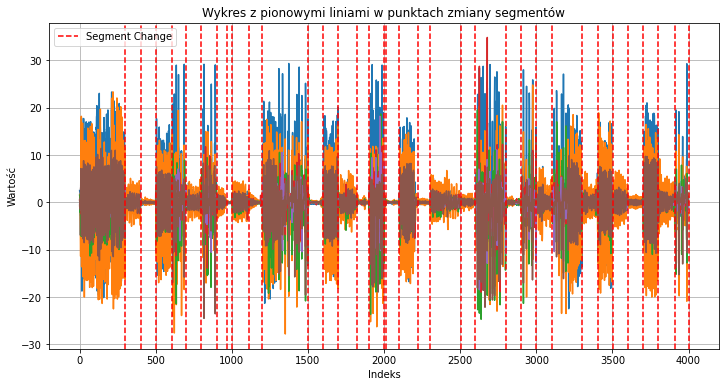

,Metryka,Wartość
0,Acc,0.994030
1,Prec,0.941176
2,Recall,0.941176
3,F1,0.941176
4,ASC,1.000000
5,ASD,4.411765
6,ADT,0.323529


In [132]:
algo = rpt.BottomUp(model="normal")
algo.fit(random_stacked)
result = algo.predict(n_bkps = 34)
# plt.plot(random_stacked)
# print(result)


plt.figure(figsize=(12, 6))
plt.plot(random_stacked)

# Dodawanie pionowych linii w punktach z result
for idx in result:
    plt.axvline(x=idx, color='r', linestyle='--', label='Segment Change' if idx == result[0] else "")

# Ustawienie legendy
plt.legend()

# Wyświetlanie wykresu
plt.xlabel('Indeks')
plt.ylabel('Wartość')
plt.title('Wykres z pionowymi liniami w punktach zmiany segmentów')
plt.grid(True)
plt.show()

TP,TN,FP,FN = calculate_TP_TN_FP_FN(4000,result[:-1],change_points,50)
ASC = calculateASC(4000,result[:-1],change_points,50)
ASD = calculateASD(4000,result[:-1],change_points,50)
ADT = calculateADT(4000,result[:-1],change_points,50)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})

evaluation

# Ruptures - binarySeg

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


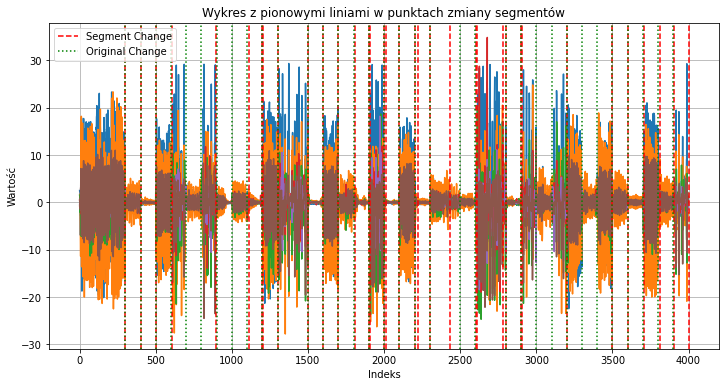

,Metryka,Wartość
0,Acc,0.992138
1,Prec,0.764706
2,Recall,0.764706
3,F1,0.764706
4,ASC,0.970588
5,ASD,4.696970
6,ADT,0.424242


In [133]:
algo = rpt.Binseg(model="normal")
algo.fit(random_stacked)
result = algo.predict(n_bkps = 34)
# plt.plot(random_stacked)
# print(result)


plt.figure(figsize=(12, 6))
plt.plot(random_stacked)

# Dodawanie pionowych linii w punktach z result
for idx in result:
    plt.axvline(x=idx, color='r', linestyle='--', label='Segment Change' if idx == result[0] else "")


for idx in change_points:
    plt.axvline(x=idx, color='g', linestyle=':', label='Original Change' if idx == result[0] else "")


# Ustawienie legendy
plt.legend()

# Wyświetlanie wykresu
plt.xlabel('Indeks')
plt.ylabel('Wartość')
plt.title('Wykres z pionowymi liniami w punktach zmiany segmentów')
plt.grid(True)
plt.show()

zone_size = 30

TP,TN,FP,FN = calculate_TP_TN_FP_FN(4000,result[:-1],change_points,zone_size)
ASC = calculateASC(4000,result[:-1],change_points,zone_size)
ASD = calculateASD(4000,result[:-1],change_points,zone_size)
ADT = calculateADT(4000,result[:-1],change_points,zone_size)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})

evaluation

# Ruptures - Pelt

In [ ]:
algo = rpt.Pelt(model="l2")
algo.fit(random_stacked)
result = algo.predict(pen=1100)
# plt.plot(random_stacked)
# print(result)


plt.figure(figsize=(12, 6))
plt.plot(random_stacked)

# Dodawanie pionowych linii w punktach z result
for idx in result:
    plt.axvline(x=idx, color='r', linestyle='--', label='Segment Change' if idx == result[0] else "")


for idx in change_points:
    plt.axvline(x=idx, color='g', linestyle=':', label='Original Change' if idx == result[0] else "")


# Ustawienie legendy
plt.legend()

# Wyświetlanie wykresu
plt.xlabel('Indeks')
plt.ylabel('Wartość')
plt.title('Wykres z pionowymi liniami w punktach zmiany segmentów')
plt.grid(True)
plt.show()

zone_size = 30

TP,TN,FP,FN = calculate_TP_TN_FP_FN(4000,result[:-1],change_points,zone_size)
ASC = calculateASC(4000,result[:-1],change_points,zone_size)
ASD = calculateASD(4000,result[:-1],change_points,zone_size)
ADT = calculateADT(4000,result[:-1],change_points,zone_size)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})

evaluation

# Ruptures - kernelcpd

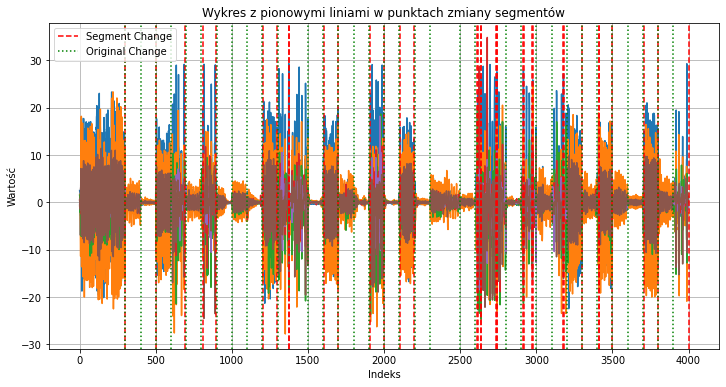

,Metryka,Wartość
0,Acc,0.988195
1,Prec,0.647059
2,Recall,0.647059
3,F1,0.647059
4,ASC,0.794118
5,ASD,8.851852
6,ADT,0.481481


In [75]:
algo = rpt.KernelCPD()
algo.fit(random_stacked)
result = algo.predict(n_bkps = 34)
# plt.plot(random_stacked)
# print(result)


plt.figure(figsize=(12, 6))
plt.plot(random_stacked)

# Dodawanie pionowych linii w punktach z result
for idx in result:
    plt.axvline(x=idx, color='r', linestyle='--', label='Segment Change' if idx == result[0] else "")


for idx in change_points:
    plt.axvline(x=idx, color='g', linestyle=':', label='Original Change' if idx == result[0] else "")


# Ustawienie legendy
plt.legend()

# Wyświetlanie wykresu
plt.xlabel('Indeks')
plt.ylabel('Wartość')
plt.title('Wykres z pionowymi liniami w punktach zmiany segmentów')
plt.grid(True)
plt.show()

zone_size = 30

TP,TN,FP,FN = calculate_TP_TN_FP_FN(4000,result[:-1],change_points,zone_size)
ASC = calculateASC(4000,result[:-1],change_points,zone_size)
ASD = calculateASD(4000,result[:-1],change_points,zone_size)
ADT = calculateADT(4000,result[:-1],change_points,zone_size)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})

evaluation

In [ ]:
# import numpy as np
# from tslearn.hmm import GaussianHMM

# # Przykładowe dane
# X = np.array([[0.5], [1.0], [0.5], [1.0], [0.5]])

# # Utworzenie modelu HMM
# model = GaussianHMM(n_components=2, n_iter=100)

# # Dopasowanie modelu do danych
# model.fit(X)

# # Dekodowanie stanów ukrytych (segmentacja)
# logprob, states = model.decode(X, algorithm="viterbi")
# print("Log-probability:", logprob)
# print("Segmenty:", states)


# Claspy

In [ ]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset

dataset, window_size, true_cps, time_series = load_tssb_dataset(names=("CricketX",)).iloc[0,:]
clasp = BinaryClaSPSegmentation()

help(rpt.Binseg )
help(algo.predict )
#clasp.fit_predict(random_stacked)


# Load 10 datasets

-
2


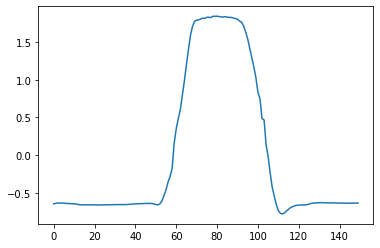

-
2


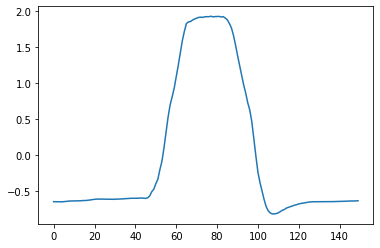

-
1


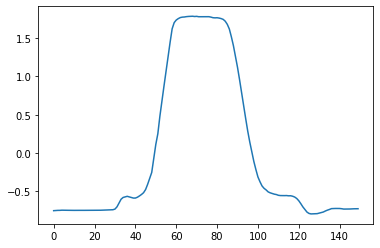

0     2
1     2
2     1
3     1
4     2
5     2
6     2
7     2
8     2
9     1
10    1
11    1
12    1
13    1
14    2
15    1
16    2
17    2
18    1
19    2
20    1
21    1
22    1
23    2
24    1
25    2
26    1
27    1
28    2
29    1
30    1
31    2
32    2
33    1
34    2
35    1
36    2
37    2
38    2
39    2
40    2
41    1
42    1
43    1
44    2
45    2
46    1
47    2
48    1
49    2
Name: class_val, dtype: object
[ 300  600 1350 2100 2250 2400 2700 2850 3000 3450 3600 3750 3900 4200
 4350 4650 4950 5100 5250 5400 6150 6600 6900 7050 7200 7350]


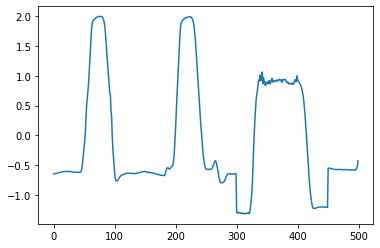

In [178]:
from sktime.datasets import load_airline, load_basic_motions, load_arrow_head, load_gunpoint, load_osuleaf, load_italy_power_demand, load_shampoo_sales, load_longley, load_uschange, load_macroeconomic

# Wczytywanie 10 różnych zestawów danych
data1 = load_airline()
data2 = load_basic_motions(return_type="numpy3d")
data3 = load_arrow_head()
gun= load_gunpoint(split="Train",return_X_y=False )
data5 = load_osuleaf()
data6 = load_italy_power_demand()
data7 = load_shampoo_sales()
data8 = load_longley()
data9 = load_uschange()
data10 = load_macroeconomic()

#help(load_basic_motions)



print("-")
print(gun.iloc[0,1])
plt.plot(gun.iloc[0,0])
plt.show()
print("-")
print(gun.iloc[1,1])
plt.plot(gun.iloc[1,0])
plt.show()
print("-")
print(gun.iloc[3,1])
plt.plot(gun.iloc[3,0])
plt.show()

# gun_stacked, change_points = stack_time_series_randomly(gun,42,150)

# gun_stacked_ndarray = dataframe_to_ndarray(gun_stacked)

change_points = gun.iloc[:,1]

print(change_points)
ch = np.array([],dtype="int64")
l_c = change_points[0]
for i,p in change_points.items():
    if(l_c != p):
        ch = np.append(ch,int(i*150))
    l_c = p
change_points  = ch
gun_stacked = stack_time_series(gun,150)
gun_stacked_ndarray = dataframe_to_ndarray(gun_stacked)

# x = np.array(X_train).transpose()
print(change_points)
plt.plot(gun_stacked_ndarray[5100:5600])
#print(y_train)


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


,Metryka,Wartość
0,Acc,0.991116
1,Prec,0.235294
2,Recall,0.307692
3,F1,0.266667
4,ASC,0.346154
5,ASD,37.777778
6,ADT,0.777778


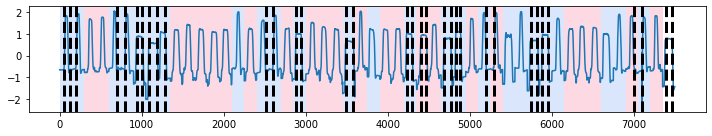

In [179]:
algo = rpt.BottomUp(model="normal")
algo.fit(gun_stacked_ndarray)
result = algo.predict(n_bkps = 34)
# plt.plot(random_stacked)
# print(result)
n = len(gun_stacked_ndarray)

TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],change_points,50)
ASC = calculateASC(n,result[:-1],change_points,50)
ASD = calculateASD(n,result[:-1],change_points,50)
ADT = calculateADT(n,result[:-1],change_points,50)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})
#help(rpt.BottomUp)

rpt.display(gun_stacked_ndarray, change_points,result)
evaluation

# PenDigits

In [247]:
filepath = './datasets/pen_digits/PenDigits_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
# print((df.iloc[1,0]))
# # print(len(df.iloc[1,0][0]))
# print((df.iloc[1,1]))
# print(df.shape)
pen_stacked , ch = stack_time_series(df,43,8)
pen_stacked_ndarray = dataframe_to_ndarray(pen_stacked)
# print(pen_stacked.shape)
# print(pen_stacked_ndarray)

#plt.plot(pen_stacked_ndarray[0:150])
# data = pen_stacked_ndarray[8:16]
# x = pen_stacked_ndarray[:, 0]
# y = pen_stacked_ndarray[:, 1]
# print(data)
# # Tworzenie wykresu
# plt.figure(figsize=(10, 6))  # Opcjonalnie, ustawienie rozmiaru wykresu
# plt.scatter(x, y, s=10)  # s=10 ustawia rozmiar punktów
# plt.xlabel('X axis')
# plt.ylabel('Y axis')
# plt.title('Scatter Plot of Points')
# plt.grid(True)
# plt.show()

algo = rpt.BottomUp(model="normal")
algo.fit(pen_stacked_ndarray)
result = algo.predict(n_bkps = len(ch))
# plt.plot(random_stacked)
# print(result)
n = len(pen_stacked_ndarray)
change_points = ch
TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],change_points,50)
ASC = calculateASC(n,result[:-1],change_points,50)
ASD = calculateASD(n,result[:-1],change_points,50)
ADT = calculateADT(n,result[:-1],change_points,50)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})
#help(rpt.BottomUp)

rpt.display(pen_stacked_ndarray, ch,result)



TypeError: stack_time_series() takes 2 positional arguments but 3 were given

# HearBeat

In [252]:
filepath = './datasets/heart_beat/HeartBeat_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
# print((df.iloc[1,0]))
# # print(len(df.iloc[1,0][0]))
# print((df.iloc[1,1]))

# pen_stacked , ch = stack_time_series(df,43,8)
# pen_stacked_ndarray = dataframe_to_ndarray(pen_stacked)

In [256]:

print((df))
print((df.iloc[0,1]))
print((df.iloc[0,0].shape))
print(len(df.iloc[0,0][0]))
heart_stacked , ch = stack_time_series_randomly(df,43,405)
heart_stacked_ndarray = dataframe_to_ndarray(heart_stacked)

#print(df.iloc[0,0][0])
print(heart_stacked_ndarray)
print(heart_stacked_ndarray.shape)

print(type(df.iloc[0,0][0]) == np.void)

                                             Heartbeat       target
0    [[0.000949, 0.001488, 0.000314, 0.000995, 0.00...    b'normal'
1    [[0.020264, 0.017023, 0.006052, 0.00395, 0.023...    b'normal'
2    [[0.021082, 0.020687, 0.009948, 0.002039, 0.00...    b'normal'
3    [[0.001634, 0.002511, 0.003524, 0.006575, 0.00...    b'normal'
4    [[0.020809, 0.007473, 0.012304, 0.01134, 0.012...    b'normal'
..                                                 ...          ...
199  [[0.002383, 0.003405, 0.004029, 0.0046, 0.0039...  b'abnormal'
200  [[0.002211, 0.001956, 0.002747, 0.000866, 0.00...  b'abnormal'
201  [[0.009989, 0.002671, 0.001707, 0.001381, 0.00...  b'abnormal'
202  [[0.000815, 0.001325, 0.00128, 0.001586, 0.001...  b'abnormal'
203  [[0.002995, 0.003105, 0.00304, 0.00068, 0.0044...  b'abnormal'

[204 rows x 2 columns]
b'normal'
(61,)
405
61
[[4.6200e-04 1.5670e-03 3.9800e-04 ... 3.3699e-01 3.2916e-01 7.1965e-01]
 [1.2650e-03 1.9470e-03 1.1330e-03 ... 3.8719e-01 5.3004e-01 6.1

[  810  2835  3240  4455  4860  6075  6480  7695  8910 10935 11340 11745
 13365 14175 14580 19035 19845 20250 20655 22275 23085 25515 25920 27540
 28755 29565 30375 37665 38070 40905 41310 41715 42120 42525 43335 43740
 44145 44955 46575 47385 47790 51840 52245 53055 53460 54270 54675 56295
 56700 57105 57510 58725 59130 59535 59940 61965 62775 65205 65610 66420
 66825 68445 68850 69255 69660 71280 71685 72495 72900 74115 74520 76545
 76950 79785 80595 81000 81810]


(<Figure size 720x144 with 1 Axes>, [<Axes: >])

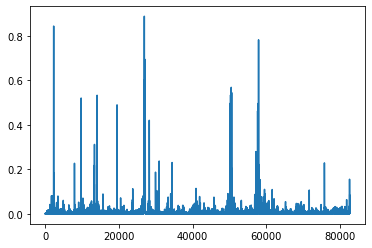

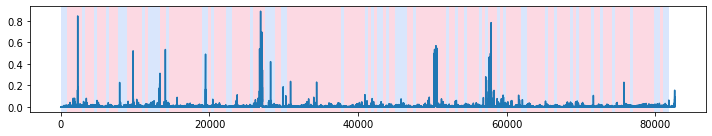

In [267]:
plt.plot(heart_stacked_ndarray[:,0])
print(ch)
rpt.display(heart_stacked_ndarray[:,0], ch)

In [297]:
data = heart_stacked_ndarray[:,0]
algo = rpt.BottomUp(model="l1")
algo.fit(data)
result = algo.predict(n_bkps = len(ch))
# plt.plot(random_stacked)
# print(result)
n = 82620
change_points = ch
TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],change_points,50)
ASC = calculateASC(n,result[:-1],change_points,50)
ASD = calculateASD(n,result[:-1],change_points,50)
ADT = calculateADT(n,result[:-1],change_points,50)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})
#help(rpt.BottomUp)

rpt.display(heart_stacked_ndarray[:,0], ch,result)
evaluation

IndexError: index 86184 is out of bounds for axis 0 with size 82620

# Cricket


1197
6
(129276, 6)


(<Figure size 720x864 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       dtype=object))

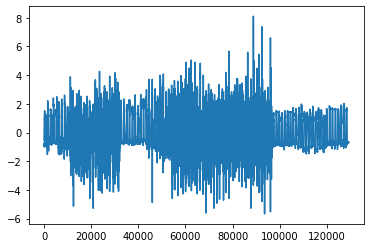

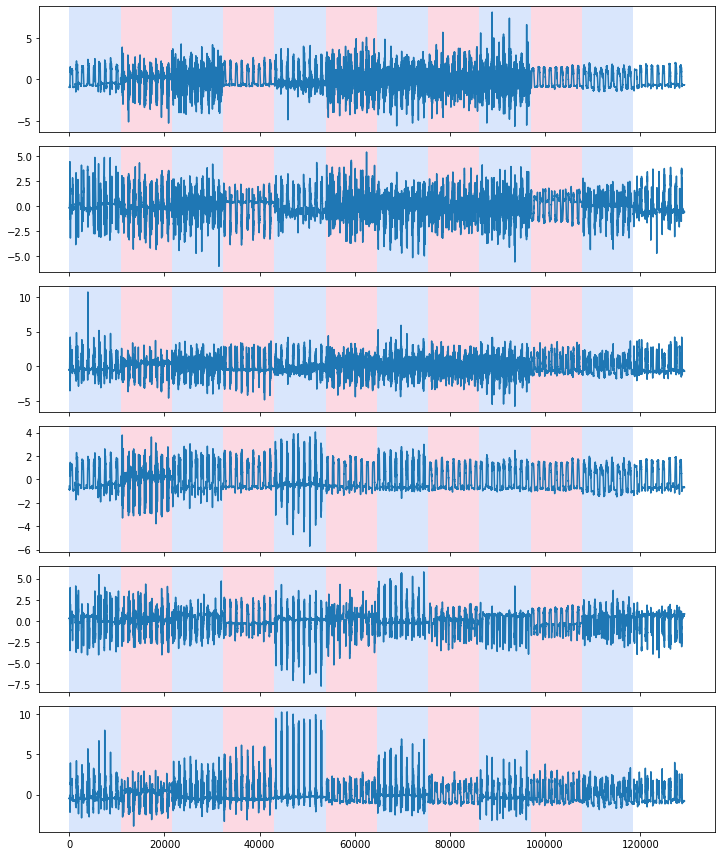

In [302]:
filepath = './datasets/Cricket/Cricket_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

print(len(df.iloc[0,0][0]))

cricet_stacked,ch  = stack_time_series_randomly(df,False)
cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)

# #print(df.iloc[0,0][0])
# print(heart_stacked_ndarray)
print(cricet_stacked_ndarray.shape)
plt.plot(cricet_stacked_ndarray[:,0])
# print(type(df.iloc[0,0][0]) == np.void)
rpt.display(cricet_stacked_ndarray, ch)

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2938.090909090909


,Metryka,Wartość
0,Acc,0.999969
1,Prec,0.909091
2,Recall,0.909091
3,F1,0.909091
4,ASC,1.000000
5,ASD,857.090909
6,ADT,0.363636


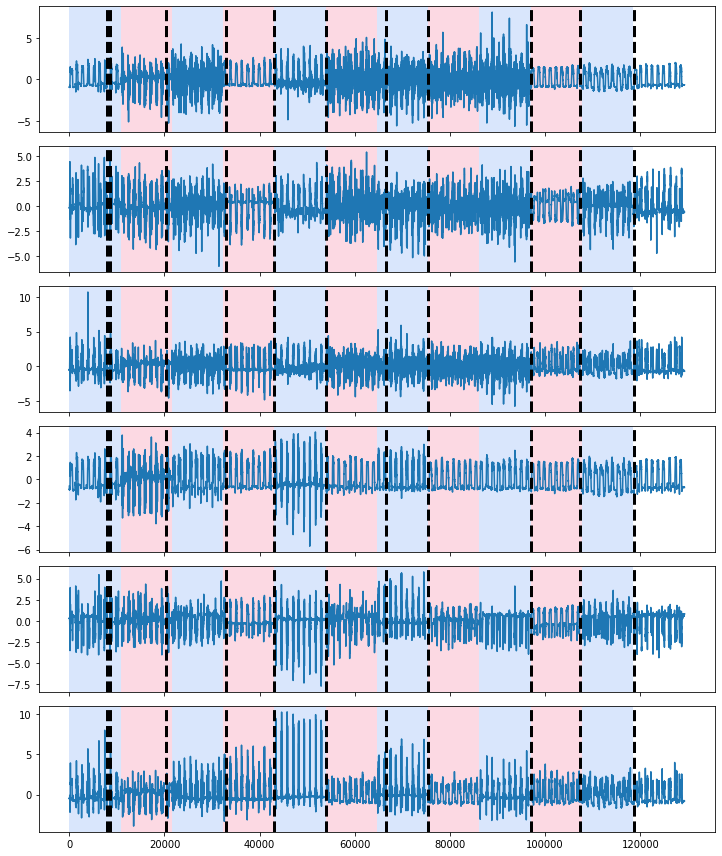

In [305]:
result,eval =  predict_change_points(cricet_stacked_ndarray,cricet_stacked_ndarray.shape[0],ch)
rpt.display(cricet_stacked_ndarray, ch,result)
eval
